# Practice using RNNs in PyTorch

In [71]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np

import matplotlib.pyplot as plt


### Simplest RNN architecture

In [ ]:
class SimpleRNN(nn.Module):
    """Make a simple RNN model.
    
    Parameters
    ----------
    input_size : int
        Size of the input features.
    hidden_size : int
        Size of the hidden state.
    output_size : int
        Size of the output features.
    num_layers : int, optional
        Number of recurrent layers (default is 1).
    batch_first : bool, optional
        If True, the input and output tensors are provided as (batch, seq, feature).
        Default: True.
    
    Examples
    --------
    >>> model = SimpleRNN(input_size=10, hidden_size=20, output_size=5)
    
    Returns
    -------
    model : SimpleRNN
        An instance of the SimpleRNN class.
    """

    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Define the output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        # Pass through RNN layer
        out, hidden = self.rnn(x, hidden)

        # Pass the output of the last time step to the fully connected layer
        out = self.fc(out[:, -1, :])
        return out, hidden

    def init_hidden(self, batch_size):
        # Initialize hidden state with zeros
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

### Simulate data of sinusoids

Different amplitudes, periods, and vertical shifts

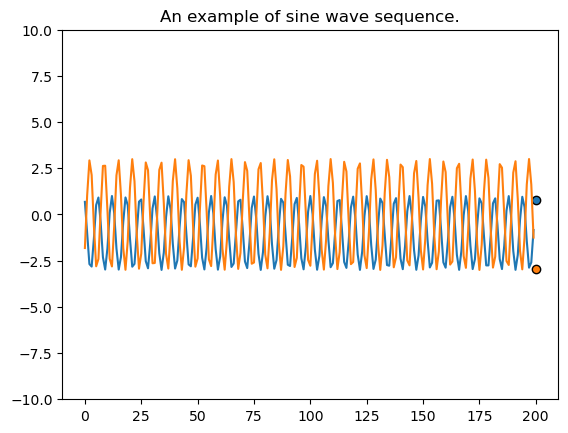

In [67]:
def generate_sine_data(seq_length=50, 
                       num_samples=1000,
                       ):
    """Simulate sine wave data for training.
    
    Parameters
    ----------
    seq_length : int
        Length of the sequence.
    num_samples : int
        Number of samples to generate.

    Returns
    -------
    X : numpy.ndarray
        Input data of shape (num_samples, seq_length, 1).
    y : numpy.ndarray
        Target data of shape (num_samples,).
    """

    X = []
    y = []
    for _ in range(num_samples):

        # create amplitude, period, and vertical shift
        amplitude = np.random.randint(1,4)
        period = np.random.randint(1,4)
        vertical_shift = np.random.randint(-3,3)

        start = np.random.rand() * 2 * np.pi
        ts = np.array([amplitude* np.sin(period * (start + i)) + vertical_shift 
                       for i in range(seq_length + 1)])
        X.append(ts[:-1].reshape(-1, 1))
        y.append(ts[-1])
    return np.array(X), np.array(y)

X, y = generate_sine_data(seq_length=200,num_samples=2)
plt.plot(X[0],'-')
plt.plot(X[1],'-')
plt.scatter(len(X[0]), y[0],edgecolors='k')
plt.scatter(len(X[1]), y[1],edgecolors='k')
plt.title("An example of sine wave sequence.")

plt.ylim(-10,10)

plt.show()

### This example predicts the last value of the sinusoid

In [72]:
# Parameter settings for the RNN
input_size = 1
hidden_size = 10
output_size = 1
num_layers = 2
batch_size = 3
seq_length = 100

# Define the RNN model for sinusoids
# You always initialize your Class object before training
rnn = SimpleRNN(input_size, hidden_size, output_size, num_layers)

# Define loss function and optimizer
# Mean Squared Error Loss is a common choice for regression tasks (MSELoss)
# The lasso loss is a good choice for regression tasks + regularization (L1Loss)
# Binary cross entropy loss is a good choice for binary classification tasks (BCELoss)
# Cross entropy loss is a good choice for multi-class classification tasks (CrossEntropyLoss)
criterion = nn.MSELoss()

# The main optimizers are Adam, RMSprop, and SGD
# Adam is a good default choice for most problems
# SGD is a good choice for large datasets
# But SGD is not a good choice for small datasets
# Because there is a lot of noise in the gradients
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

# Convert training data to PyTorch tensors
X_train, y_train = generate_sine_data(seq_length=100,num_samples=10000)
X_test, y_test = generate_sine_data(seq_length=100,num_samples=2000)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Training parameters
# Number of epochs is how many times we repeat the training on the same data
# Batch size is the number of samples we use to calculate the gradients
num_epochs = 10
batch_size = 50

# Create a TensorDataset from your training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Define a DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):

    # You use .train() to set the model to training mode
    # You use .eval() to set the model to evaluation mode
    # You do this so the model does not update the weights during evaluation
    rnn.train()
    epoch_loss = 0.0

    # For some model fitting, we write a validate function to keep track of progress
    # Within the validation function, we use .eval() to set the model to evaluation mode
    # Which is why best practice is to put .train() at the beginning of each epoch loop

    # Iterate over batches
    for X_batch, y_batch in train_loader:

    # # The commented is naive way to manage batching
    # for i in range(0, len(X_train_tensor), batch_size):
    #     # Get the current batch
    #     X_batch = X_train_tensor[i:i+batch_size]
    #     y_batch = y_train_tensor[i:i+batch_size]

        # Initialize hidden state
        hidden = rnn.init_hidden(X_batch.size(0))

        # Forward pass
        output, hidden = rnn(X_batch, hidden)
        loss = criterion(output.squeeze(), y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        # You always want to zero out the gradients before the backward pass
        # Otherwise the gradients will accumulate
        loss.backward()
        # .backward() is where we calculate the gradients
        optimizer.step()
        # .step() is where we update the weights

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(X_train_tensor):.4f}")

Epoch 1/10, Loss: 0.0681
Epoch 2/10, Loss: 0.0498
Epoch 3/10, Loss: 0.0190
Epoch 4/10, Loss: 0.0056
Epoch 5/10, Loss: 0.0030
Epoch 6/10, Loss: 0.0020
Epoch 7/10, Loss: 0.0015
Epoch 8/10, Loss: 0.0011
Epoch 9/10, Loss: 0.0009
Epoch 10/10, Loss: 0.0007


In [73]:
# Set the model to evaluation mode
rnn.eval()

# Initialize hidden state for the test data
hidden = rnn.init_hidden(X_test_tensor.size(0))

# Perform a forward pass on the test data
with torch.no_grad():  # Disable gradient computation for testing
    output, hidden = rnn(X_test_tensor, hidden)

# Calculate the loss on the test data
test_loss = criterion(output.squeeze(), y_test_tensor)

# .squeeze() is used to remove the extra dimension
# i.e., whenever dimension has 1 element, it is removed
# This is useful when we want to compare the output and the target
# It helps with compatability

print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0347


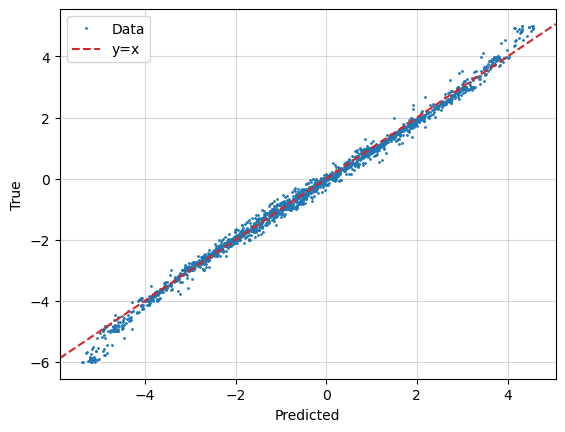

In [81]:
plt.plot(output,
         y_test_tensor,
         'o',
         markersize=1,
         label='Data')
plt.axline((0, 0), 
           slope=1, 
           color='tab:red', 
           linestyle='--', 
           label='y=x')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.grid(alpha=0.5)
plt.legend()

## This example does more than 1 prediction

In [96]:
def generate_sine_data_multistep(seq_length=50, num_samples=1000, pred_steps=10):
    """Simulate sine wave data for multi-step prediction.

    Parameters
    ----------
    seq_length : int
        Length of the input sequence.
    num_samples : int
        Number of samples to generate.
    pred_steps : int
        Number of future steps to predict.

    Returns
    -------
    X : numpy.ndarray
        Input data of shape (num_samples, seq_length, 1).
    y : numpy.ndarray
        Target data of shape (num_samples, pred_steps).
    """
    X = []
    y = []
    for _ in range(num_samples):
        amplitude = np.random.randint(1, 4)
        period = np.random.randint(1, 4)
        vertical_shift = np.random.randint(-3, 3)

        start = np.random.rand() * 2 * np.pi
        ts = np.array([amplitude * np.sin(period * (start + i)) + vertical_shift
                       for i in range(seq_length + pred_steps)])
        X.append(ts[:seq_length].reshape(-1, 1))
        y.append(ts[seq_length:])
    return np.array(X), np.array(y)

# Update the RNN model to output sequences
class MultiStepRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(MultiStepRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)


    # The forward method is the same as before except output is now a sequence
    # Not the index -1
    # This is the only difference between SimpleRNN and MultiStepRNN
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)  # Predict for each time step
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size)

# Generate multi-step data
seq_length = 100
pred_steps = 10
X_train, y_train = generate_sine_data_multistep(seq_length=seq_length, num_samples=1000, pred_steps=pred_steps)
X_test, y_test = generate_sine_data_multistep(seq_length=seq_length, num_samples=200, pred_steps=pred_steps)

# Parameter settings for the RNN
input_size = 1
hidden_size = 10
num_layers = 2

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Update the model and training parameters
output_size = pred_steps
rnn = MultiStepRNN(input_size, hidden_size, output_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

# Training loop
num_epochs = 10
batch_size = 50
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    rnn.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        hidden = rnn.init_hidden(X_batch.size(0))
        output, hidden = rnn(X_batch, hidden)
        # Note how loss has changed
        # This is the main change from SimpleRNN to MultiStepRNN
        loss = criterion(output[:, -1, :].squeeze(), y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# Evaluate the model
rnn.eval()
hidden = rnn.init_hidden(X_test_tensor.size(0))
with torch.no_grad():
    output, hidden = rnn(X_test_tensor, hidden)
test_loss = criterion(output[:, -1, :].squeeze(), y_test_tensor)
print(f"Test Loss: {test_loss.item():.4f}")


Epoch 1/10, Loss: 5.6251
Epoch 2/10, Loss: 5.3487
Epoch 3/10, Loss: 4.9921
Epoch 4/10, Loss: 4.3327
Epoch 5/10, Loss: 3.6703
Epoch 6/10, Loss: 3.2795
Epoch 7/10, Loss: 3.0722
Epoch 8/10, Loss: 2.9601
Epoch 9/10, Loss: 2.8838
Epoch 10/10, Loss: 2.8289
Test Loss: 2.9196


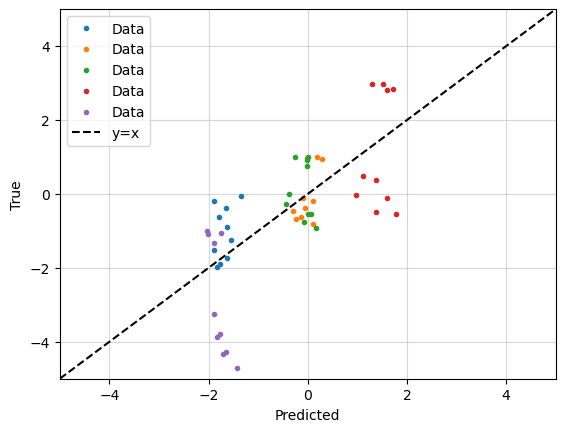

In [104]:
K = 5
for k in range(K):
    plt.plot(output[k,-1,:],
            y_test_tensor[k],
            'o',
            markersize=3,
            label='Data')

plt.axline((0, 0), 
           slope=1, 
           color='k', 
           linestyle='--', 
           label='y=x')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.grid(alpha=0.5)
plt.ylim(-5,5)
plt.xlim(-5,5)
plt.legend()